# **Conditional GAN**

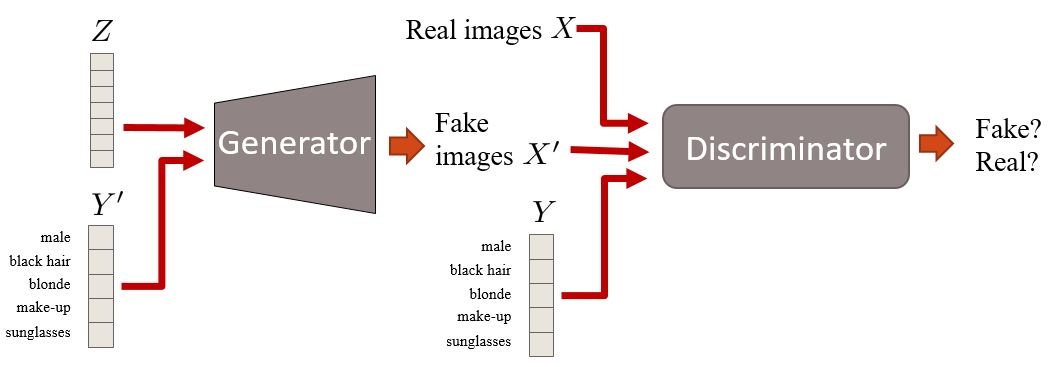

#### Conditional generative adversarial network, or cGAN for short, is a type of GAN that involves the conditional generation of images by a generator model.

In [57]:
#import required packages
import torch
import math
from torch import nn
from tqdm.auto import tqdm
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Generator

In [16]:
# Generator (for generating fake images)

class Generator(nn.Module):
  
    # z_dim : noise vector dimension
    # output_channel : tnumber of channels of the output image, it is 1 for MNIST(black and white) dataset.
    # hidden_dimension : inner dimension of the generator model

    def __init__(self, z_dimension=10, output_channel=3, hidden_dimension=64):
        super(Generator, self).__init__()

        self.z_dimension = z_dimension

        # Building the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dimension, hidden_dimension * 2),
            self.make_gen_block(hidden_dimension * 2, hidden_dimension * 4),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 8, stride=1),
            self.make_gen_block(hidden_dimension * 8, hidden_dimension * 16, stride=1),
            self.make_gen_block(hidden_dimension * 16, hidden_dimension * 4, stride=1),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 2, stride=1),
            self.make_gen_block(hidden_dimension * 2, output_channel, kernel_size=4, stride=2, final_layer=True),
        )


    # building neural block
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channel
        # output_channels : number of output channel
        # kernel_size : size of convolutional filter
        # stride : stride of the convolution
        # final_layer : boolean value, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

        # Final Layer
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
  
    # Function for completing a forward pass of the generator: Given a noise tensor, returns generated images.
    def forward(self, noise, z_dim):
        
        # noise: a noise tensor with dimensions (n_samples, z_dimension)
        

        # a noise with width = 1, height = 1, number of channels = z_dimension, number of samples = len(noise)
        #print(noise.shape)
        x = noise.view(len(noise), self.z_dimension, 1, 1)
        return self.gen(x)


    # Function for creating noise vectors: Given the dimensions (n_samples, z_dim) creates a tensor of that shape filled with random numbers 
    # from the normal distribution
    def get_noise(self, n_samples, z_dim, device='cpu'):
    
        # n_samples: the number of samples to generate, a scalar
        # z_dimension: the dimension of the noise vector, a scalar
        # device: the device type (cpu / cuda)
    
        return torch.randn(n_samples, z_dim, device=device)

## Critic

In [17]:
# Critic

class Critic(nn.Module):

    # im_chan :  number of output channel (1 channel for MNIST dataset which has balck and white image)
    # hidden_dim : number of inner channel

    def __init__(self, im_chan=13, hidden_dim=32):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim * 2, stride=1),
            self.make_crit_block(hidden_dim * 2, hidden_dim * 4),
            self.make_crit_block(hidden_dim * 4, hidden_dim * 8, stride = 1),
            self.make_crit_block(hidden_dim * 8, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, kernel_size=4, final_layer=True),
        )


    # Build the neural block
    def make_crit_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channels
        # output_channels : number of output channels
        # kernel_size : the size of each convolutional filter
        # stride : the stride of the convolution
        # final_layer : a boolean, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    # Function for completing a forward pass of the Critic: Given an image tensor, returns a 1-dimension tensor representing fake/real.
    def forward(self, image):
        # image: a flattened image tensor 
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [4]:
from torchsummary import summary
crit = Critic()
summary(crit, input_size=(13, 32, 32))

RuntimeError: ignored

## Generator Input
#### In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label.

In [18]:
# creating one-hot vectors for the labels

def get_one_hot_labels(labels, n_classes):

    # labels: tensor of labels from the dataloader, size (?)
    # n_classes: the total number of classes in the dataset
    
    return F.one_hot(labels,n_classes)



# to concatenate the one-hot class vector to the noise vector before giving it to the generator

def combine_vectors(x, y):
    
    
      # x: noise vector of shape (n_samples, z_dim), 
      # y:  one-hot class vector of shape (n_samples, n_classes)
    
    # concatenating class vector and noise vector around first dimension.
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

## Training Parameters 

In [43]:
# weight of the gradient penalty to maintain 1-Lipschitz Continuity
c_lambda = 10

# number of times to update the critic per generator update
crit_repeats = 2

# the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
cifar10_shape = (3, 32, 32)

# number of classes
n_classes = 10

# dimension of the noise vector
z_dim = 128

# ow often to display/visualize the images
display_step = 1000

# number of images per forward/backward pass
batch_size = 128

# the learning rate
lr = 0.0002

#the device type 
device = 'cuda'

# the momentum term
beta_1 = 0.5 
beta_2 = 0.999

# the number of times you iterate through the entire dataset when training
n_epochs = 50

## Downloading dataset

In [44]:
# # You can tranform the image values to be between -1 and 1 (the range of the tanh activation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    CIFAR10('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Files already downloaded and verified


### Generator input dimension

In [45]:
# the size of the conditional input dimensions 

def get_input_dimensions(z_dim, cifar10_shape, n_classes):
    
    # z_dim: the dimension of the noise vector
    # cifar10_shape: the shape of each MNIST image is (1, 28, 28)
    # n_classes: the total number of classes in the dataset

    
    # input dimensionality of the conditional generator, which takes the noise and class vectors
    generator_input_dim = z_dim + n_classes

    # the number of input channels to the crit (number_of_channel x 28 x 28 for MNIST)
    crit_im_chan = cifar10_shape[0] + n_classes

    return generator_input_dim, crit_im_chan


generator_input_dim, crit_im_chan = get_input_dimensions(z_dim, cifar10_shape, n_classes)

#### initializing generator, critic, and optimizers.

In [46]:
#generator
gen = Generator(generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

#discriminator
crit = Critic(crit_im_chan).to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

In [47]:
from torchsummary import summary
summary(gen, input_size=(74,))

TypeError: ignored

#### initializing the generator and discriminator weights to the normal distribution with mean 0 and standard deviation 0.02

In [48]:
def weights_init(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Gradient Penalty
### 1. compute gradient with respect to the mixed images
###    a. create a mixed image by weighing the fake and real image using epsilon and then adding them together. 
###    b.  get the critic's output on the mixed image<br><br>
### 2. compute gradient penalty given the gradient
###    a. magnitude of each image gradient
###    b. calculate the penalty 

In [49]:
# compute gradient with respect to the mixed images

def get_gradient(crit, real, fake, epsilon):
    
    
        # crit: the critic model
        # real: a batch of real images
        # fake: a batch of fake images
        # epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    
    # Mix the images together
    #print(real.shape)
    #print(fake.shape)
    
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,

        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]

    # Return the gradient of the critic's scores with respect to mixes of real and fake images.
    return gradient

In [50]:
# compute gradient penalty given the gradient

def gradient_penalty(gradient):
    
    #gradient: the gradient of the critic's scores, with respect to the mixed image

    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####

    # returns the gradient penalty
    return penalty

# Generator Loss

In [51]:
def get_gen_loss(crit_fake_pred):
    
    gen_loss = -1. * torch.mean(crit_fake_pred)

    # a scalar loss value
    return gen_loss

# Critic loss

In [52]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    
   
        #crit_fake_pred: the critic's scores of the fake images
        #crit_real_pred: the critic's scores of the real images
        #gp: the unweighted gradient penalty
        #c_lambda: the current weight of the gradient penalty 
    
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    # a scalar for the critic's loss
    return crit_loss

## Output Visualisation

In [83]:
# Function for visualizing images: Given a tensor of images, number of images, and
# size per image, plots and prints the images in an uniform grid.

def show_tensor_images(image_tensor, num_images=16, size=(3, 32, 32)):
    
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### For each epoch, it will process the entire dataset in batches and for every batch, it will update the discriminator and generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: -0.11022169906506316, critic loss: 7.062525486379862


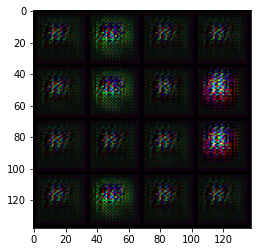

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


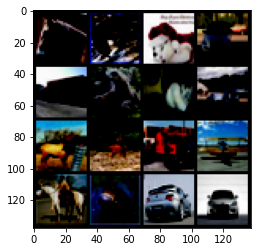

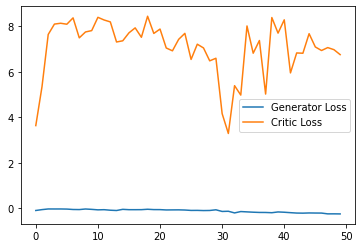

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: -0.40102674631774426, critic loss: 8.247959404349327


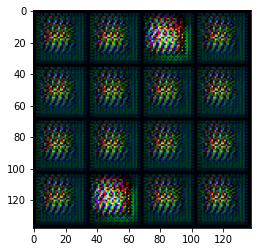

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


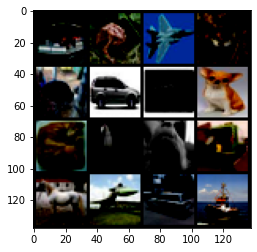

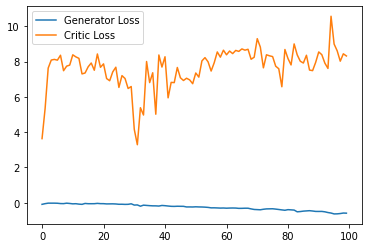

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: -1.0385439910292626, critic loss: 3.020381485924125


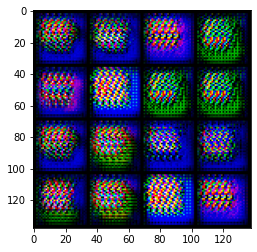

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


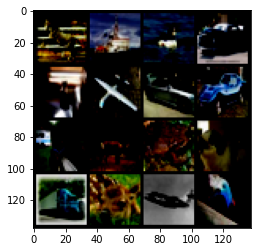

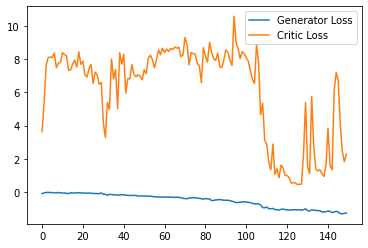

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: -1.6097829082012176, critic loss: 2.7450191009566187


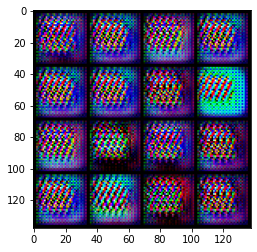

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


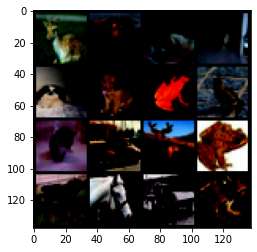

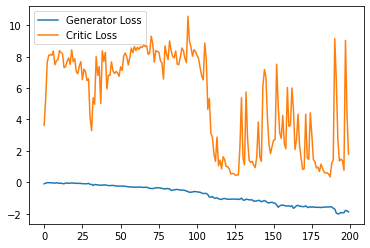

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: -2.2094039653539657, critic loss: 1.0025980705693365


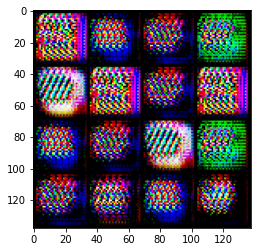

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


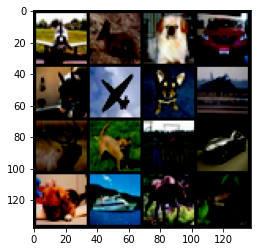

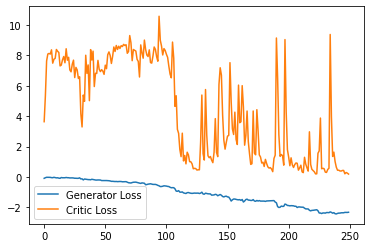

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: -2.104971868157387, critic loss: 0.9319380429536104


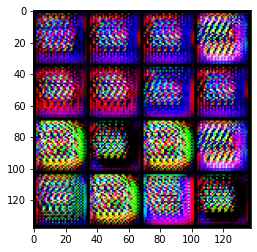

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


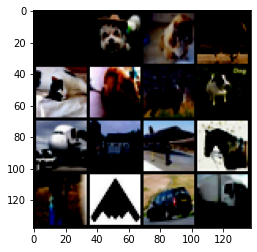

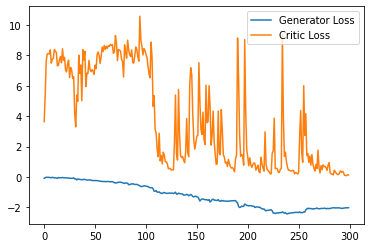

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: -1.947978391289711, critic loss: 0.13446221413929016


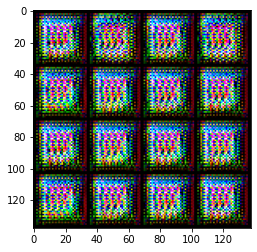

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


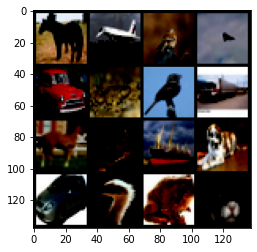

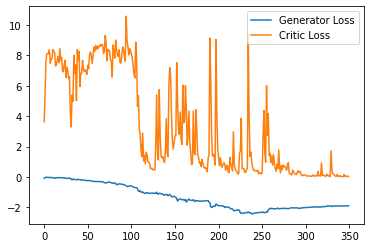

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: -1.8948744549751282, critic loss: 0.13561018781876918


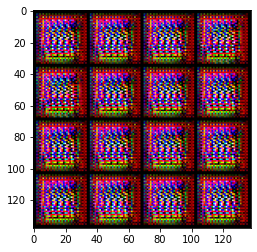

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


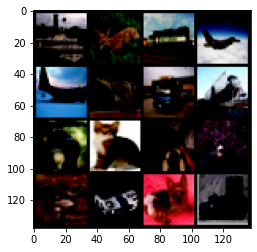

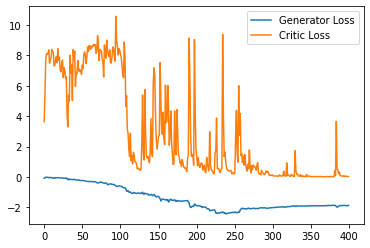

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: -1.9039370081424714, critic loss: 0.1122704552221985


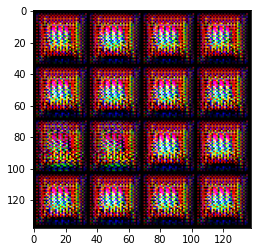

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


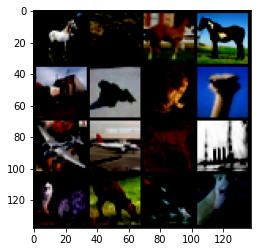

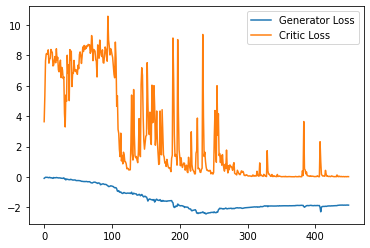

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: -1.8654252263307571, critic loss: 0.011014600644928579


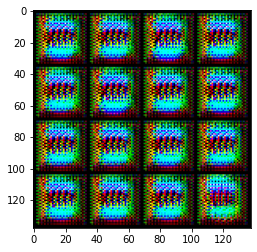

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


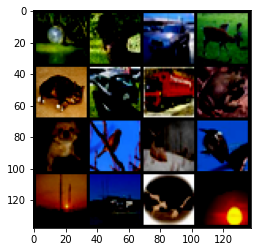

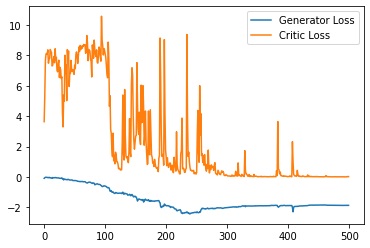

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: -1.830587967634201, critic loss: 0.16094853263531694


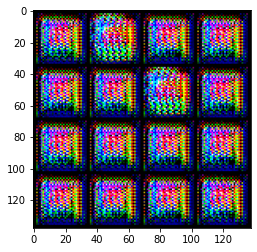

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


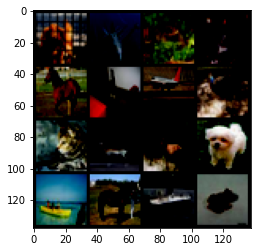

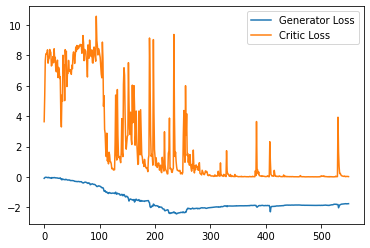

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000: Generator loss: -1.7335288146734238, critic loss: 0.017342350130231353


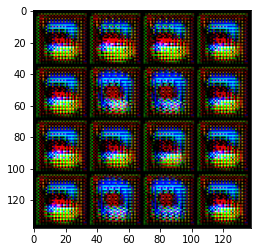

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


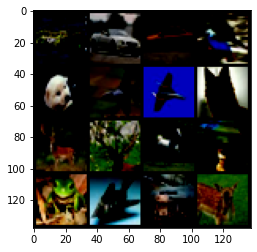

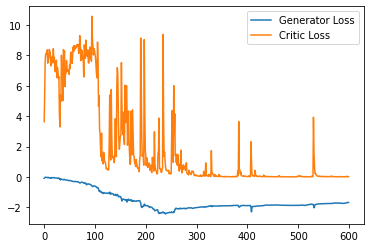

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000: Generator loss: -1.697475158572197, critic loss: 0.015905993096370367


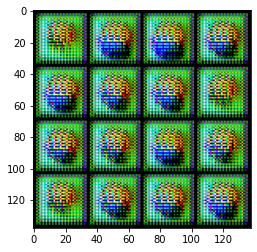

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


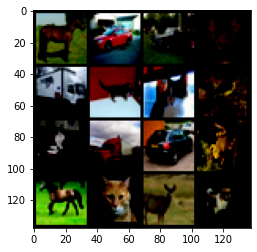

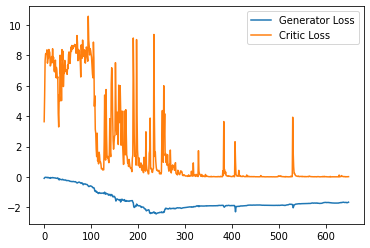

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000: Generator loss: -1.5935990906953812, critic loss: 0.1134801910892711


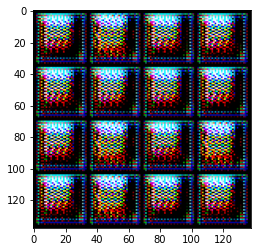

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


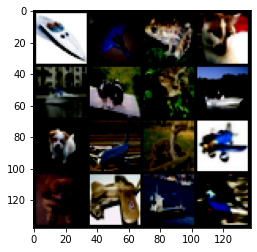

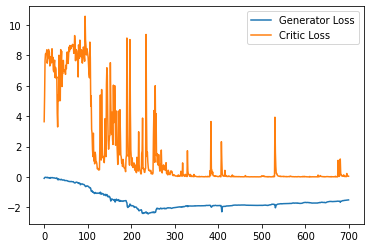

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000: Generator loss: -1.4566740663051605, critic loss: 0.04374967073061271


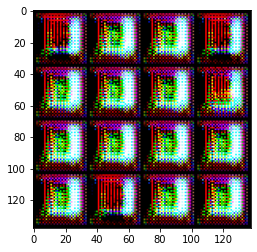

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


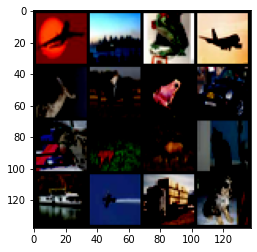

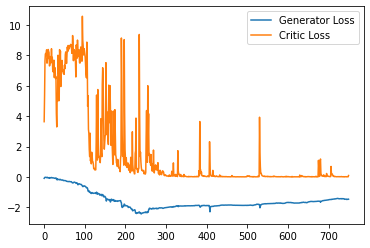

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000: Generator loss: -1.4997310063838958, critic loss: 0.010652525597601197


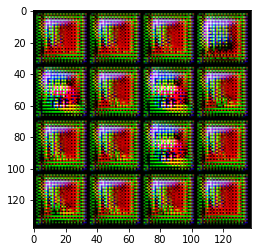

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


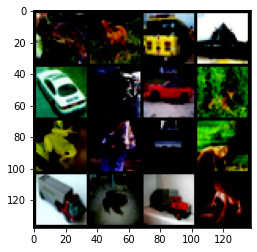

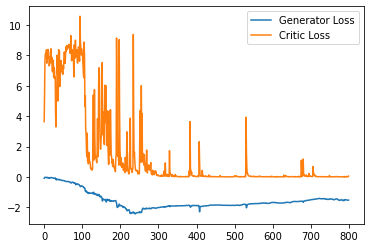

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000: Generator loss: -1.4537133002281188, critic loss: 0.008266638385313854


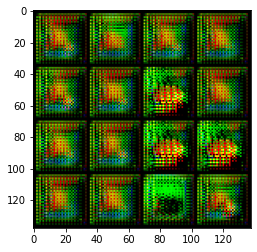

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


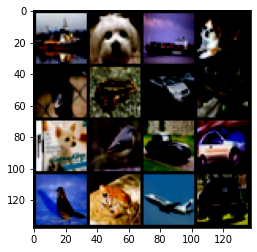

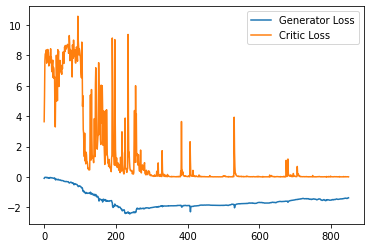

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18000: Generator loss: -1.5228035516738891, critic loss: -0.10771776209838572


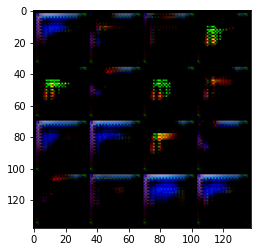

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


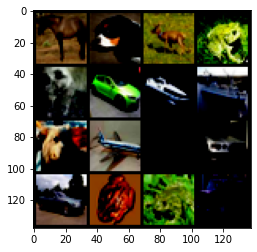

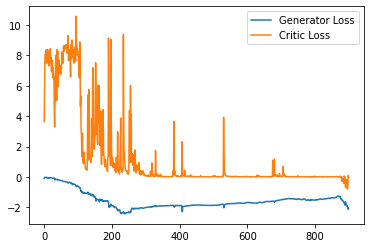

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19000: Generator loss: -2.1409096195697783, critic loss: -0.07070904060569592


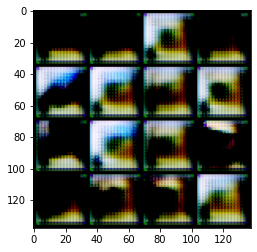

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


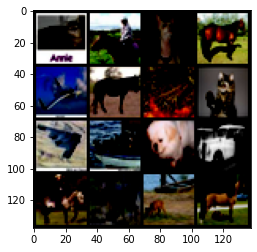

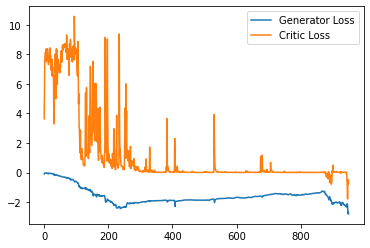

In [54]:
cur_step = 0
generator_losses = []
critic_losses = []


for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):

        cur_batch_size = len(real)
        real = real.to(device)
        labels = labels.to(device)

        mean_iteration_critic_loss = 0

        # one-hot label for generator
        one_hot_labels = get_one_hot_labels(labels, n_classes)

        # image one-hot label for discriminator
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, cifar10_shape[1], cifar10_shape[2])


        ### Update critic ###
        for _ in range(crit_repeats):

            crit_opt.zero_grad()
            fake_noise = gen.get_noise(cur_batch_size, z_dim, device=device)

            # combine noise vector and one hot class vector
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
       
            # generating fake image

            #print(noise_and_labels.shape)
            fake = gen(noise_and_labels, z_dim)

            # combining fake image with image one hot label
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

            # combining real image with image one hot label
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)


            crit_fake_pred = crit(fake_image_and_labels.detach())
            crit_real_pred = crit(real_image_and_labels)


            # check
            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real_image_and_labels, fake_image_and_labels.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise = gen.get_noise(cur_batch_size, z_dim, device=device)

        # combine noise vector and one hot class vector
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
       
        # generating fake image
        fake2 = gen(noise_and_labels, z_dim)
        fake_image_and_labels = combine_vectors(fake2, image_one_hot_labels)

        crit_fake_pred = crit(fake_image_and_labels)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1